# COVID19 ANALYSIS USING SOCIAL MEDIA DATA

After collecting tweets from users, we need to clean the data, and visualize it. The aim of this notebook is to understand how to clean and filter textual data, to then build interactive visualizations.

We will keep only the tweets mentionning COVID19 symptoms, and compare the evolution of these tweets with the evolution of hospitalizations over time.

In [1]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

# 1. Import data

We import the tweets containing symptoms. These tweets have already been filtered on the whole dataset, which contained around 55M of tweets : we only kept those in French who mention a possible COVID19 symptom and tweets that were not retweets. We also anonymized the text, removing url and usernames.

In [2]:
# Paths to data
path_to_data = "../data/"
tweets_symptoms = pd.read_csv(os.path.join(path_to_data,'list_tweets_symptoms.csv'), sep=';')
tweets_symptoms['day']=pd.to_datetime(tweets_symptoms['day'])

In [3]:
tweets_symptoms.head()

,id_str,day,anonymized_text
0,1206157336534016001,2019-12-15,Symptomatique [url]
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...
2,1216811655738413056,2020-01-13,@mention @mention Rhume toux fièvre
3,1218113362917236737,2020-01-17,Il serait temps de condamner toutes ces feigna...
4,1219872603554361344,2020-01-22,@mention Parce que ça veut dire que je serais ...


# 2. Data preparation

We want to find tweets that mention specific symptoms.

## 2.1. Text cleaning

To do so, we will first normalize the texts, by removing capital letters, and accents, since Twitter users often don't use accents. We also want to remove punctuation - to recognize hastags (eg. "#fever") as a symptom.

In [4]:
from unidecode import unidecode    # remove punctuation
import re                          # regex library

In [5]:
def clean_text(text):
    
    # remove accents
    text=unidecode(text)
    
    # lowercase
    text=text.lower()
    
    # remove punctuation, except @ and [url]
    text=re.sub(r'[^\sa-zA-Z0-9@\[\]]',' ',text)
    
    return text

In [6]:
tweets_symptoms['clean_text']=tweets_symptoms['anonymized_text'].apply(lambda x: clean_text(x))
tweets_symptoms.head()

,id_str,day,anonymized_text,clean_text
0,1206157336534016001,2019-12-15,Symptomatique [url],symptomatique [url]
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...,reformeretraite delevoye @mention appelle au...
2,1216811655738413056,2020-01-13,@mention @mention Rhume toux fièvre,@mention @mention rhume toux fievre
3,1218113362917236737,2020-01-17,Il serait temps de condamner toutes ces feigna...,il serait temps de condamner toutes ces feigna...
4,1219872603554361344,2020-01-22,@mention Parce que ça veut dire que je serais ...,@mention parce que ca veut dire que je serais ...


## 2.2. Symptoms dictionary

Next step: find the different symptoms in the tweets.

We will build a dictionary to find the different symptoms. We want this dictionary to contain familiar ways of expressing symptoms.

In [7]:
symptoms_dict_fr = {'cough' : ['toux','touss'],
                   'sore_throat' : ['maux de gorge','mal de gorge','mal a la gorge'],
                   'fever' : ['fievre'],
                   'loss_taste' : ['perte du gout','perte de l odorat','perte de lodorat','perdu le gout','perdu l odorat',
                                   'perdu lodorat','plus de gout','plus d odeur', 'plus dodeur'],
                    'breathing_difficulties' : ['difficultes a respirer','difficulte a respirer','difficultes respiratoires',
                                                'mal a respirer'],
                   'symptoms' : ['symptom']}

In [8]:
# We want to capture the tweets in which a word starts with the symptom expression
for symptom in symptoms_dict_fr.keys():
    tweets_symptoms[symptom] = (tweets_symptoms['clean_text'].str.contains\
                                    ('|'.join(['^'+x for x in symptoms_dict_fr.get(symptom)]+
                                            [' '+x for x in symptoms_dict_fr.get(symptom)])))
                                


In [9]:
#Examples?
tweets_symptoms.loc[tweets_symptoms['fever']==True, 'anonymized_text'].tolist()[:5]

['@mention @mention Rhume toux fièvre',
 '@mention Parce que ça veut dire que je serais encore en train de dormir cassé par la fièvre. Donc je refuse.',
 '«\xa0j’ai de la fièvre je tousse je préfère pas venir\xa0» alors que ça a juste une gueule de bois',
 '⚠️ En cas de fièvre, privilégiez le paracétamol. En effet, les anti-inflammatoires comme l’ibuprofène, de part leur mécanisme d’action, peuvent aggraver l’infection ! 🦠  En cas de doute, demandez conseil à un professionnel de #santé 👨\u200d⚕️👩\u200d🔬 #COVIDー19 [url]',
 'Merci. Mais je suis inquiète sa fièvre ne descend et sa toux est persistante. Un simple rhume le coronavirus ?? Je ne sais pas mais Je soigne mon bébé malgré tout et nous restons chez nous  tous les 5 . Dieu veille.']

In [10]:
print('Number of tweets mentionning each symptom:')
tweets_symptoms[symptoms_dict_fr.keys()].sum()

Number of tweets mentionning each symptom:


cough                     4266
sore_throat                577
fever                     2551
loss_taste                 485
breathing_difficulties     436
symptoms                  5583
dtype: int64

# 3. Visualization

Next step: we will visualize the data, using plotly for interactive visualizations!

[Plotly](https://plotly.com/python/) allows you to build interactive graphs in Python Jupyter Notebooks. You can then easily convert these visualizations to .html, to build a dashboard presenting you results. It can also easily be combined with [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/), a tool to add widgets and make your plots even more interactive -- this option cannot be converted to .html though.

In [11]:
from matplotlib import pyplot as plt
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
py.init_notebook_mode(connected = True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

## 3.1. Evolution of symptoms over time

First, we want to see how each symptom evolves over time.

We first group the data by day.

In [12]:
tweets_symptoms['n_symptom']=1
tweets_day=tweets_symptoms.groupby('day').agg('sum').reset_index().drop(columns=['id_str'])
tweets_day.head()

,day,cough,sore_throat,fever,loss_taste,breathing_difficulties,symptoms,n_symptom
0,2019-12-02,1,1,0,1,0,1,4.0
1,2019-12-03,1,1,2,0,0,5,9.0
2,2019-12-04,1,0,2,0,0,2,5.0
3,2019-12-05,1,0,2,0,0,2,5.0
4,2019-12-06,1,1,2,0,1,1,6.0


In [13]:
def plot_symptoms_evolution(average_week=False) :
    
    
    traces=[]
    
    for value in symptoms_dict_fr.keys():
        y_value = tweets_day[value].values
        if average_week==True:
            y_value = tweets_day[value].rolling(window=7).mean()
        traces.append(go.Scatter(x = tweets_day['day'], 
                                 y = y_value,
                                mode = 'lines',
                                name = value))
    
    layout = go.Layout(title="Evolution of tweets mentionning COVID19 symptoms in Ile-de-France")
    if average_week==True:
        layout=go.Layout(title='Evolution of tweets mentionning COVID19 symptoms in Ile-de-France - average week')
    fig = go.Figure(traces, layout)
    
    fig.add_shape(dict(type="rect",
                       yref='paper',
                       x0='2020-03-17',
                       y0=0,
                       x1='2020-05-11',
                       y1=1,
                       fillcolor="LightSalmon",
                       opacity=0.2,
                       layer='below',
                       line_width=0))
    
    fig.update_layout(annotations=[dict(
        x='2020-04-15',
        y=0.9,
        yref="paper",
        text="Lockdown (France)", showarrow=False)])
    
    py.iplot(fig)

In [14]:
plot_symptoms_evolution()

In [15]:
plot_symptoms_evolution(average_week=True)

Note : The plots are interactive, you can select only a few symptoms, hover to see the value, or zoom.

## 3.2. Comparision with emergencies data

We would like now to compare all these tweets mentionning symptoms, with medical data about the evolution of the pandemic. We will take data from Santé Publique France about [emergencies and SOS médecins data related to COVID19](https://www.data.gouv.fr/fr/datasets/donnees-des-urgences-hospitalieres-et-de-sos-medecins-relatives-a-lepidemie-de-covid-19/).

In [16]:
emergencies=pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/eceb9fb4-3ebc-4da3-828d-f5939712600a', sep=';')

# date to datetime
emergencies['date_de_passage'] = pd.to_datetime(emergencies['date_de_passage'])
emergencies['dep']=emergencies['dep'].astype(str)
# Keep only Île-De-France
emergencies = emergencies.loc[emergencies['dep'].isin(['75','77','78','91','93','94','95'])]
emergencies = emergencies.groupby(['date_de_passage']).agg('sum').reset_index()

emergencies.head()

,date_de_passage,nbre_pass_corona,nbre_pass_tot,nbre_hospit_corona,nbre_pass_corona_h,nbre_pass_corona_f,nbre_pass_tot_h,nbre_pass_tot_f,nbre_hospit_corona_h,nbre_hospit_corona_f,nbre_acte_corona,nbre_acte_tot,nbre_acte_corona_h,nbre_acte_corona_f,nbre_acte_tot_h,nbre_acte_tot_f
0,2020-02-24,0.0,15406.0,0.0,0.0,0.0,3917.0,3785.0,0.0,0.0,0.0,4761.0,0.0,0.0,1055.0,1333.0
1,2020-02-25,2.0,13530.0,0.0,0.0,1.0,3411.0,3353.0,0.0,0.0,0.0,4197.0,0.0,0.0,908.0,1197.0
2,2020-02-26,0.0,13176.0,0.0,0.0,0.0,3342.0,3246.0,0.0,0.0,0.0,3994.0,0.0,0.0,848.0,1150.0
3,2020-02-27,4.0,13538.0,0.0,2.0,0.0,3399.0,3370.0,0.0,0.0,0.0,4093.0,0.0,0.0,881.0,1167.0
4,2020-02-28,0.0,12952.0,0.0,0.0,0.0,3345.0,3130.0,0.0,0.0,0.0,3474.0,0.0,0.0,739.0,1003.0


In this dataset, we have the :
- number of passages to emergencies for suspicion of COVID19, total number of passages to emergencies ;
- number of hospitalizations COVID19, total number of hospitalizations ;
- number of medical acts from SOS médecins for suspicion of COVID19, number of medical acts.


For each variable, we have the total, as well as the type of emergencies for men(h) and women(f).

We will focus on the total numbers of emergencies for COVID19 (nbre_pass_corona, nbre_hospit_corona, nbre_acte_corona). We first define a dictionary of these emergencies.

In [17]:
emergencies_dict={'passages to emergencies':'nbre_pass_corona',
                  'hospitalizations':'nbre_hospit_corona',
                  'acts':'nbre_acte_corona'}

This time, we will build an interactive visualization with widgets, to choose which variable to display.

In [18]:
def plot_symptoms_emergencies(emergency) :
    
    emergency_type = emergencies_dict.get(emergency)
    
    
    traces=[]
    traces.append(go.Scatter(x = tweets_day['day'],
                            y = tweets_day['n_symptom'].values,
                            mode = 'lines',
                            name = 'Tweets symptoms',
                            opacity=0.3,
                            line=dict(color='red'),
                            yaxis="y1"))
    traces.append(go.Scatter(x = tweets_day['day'],
                            y = tweets_day['n_symptom'].rolling(7).mean(),
                            mode = 'lines',
                             line=dict(color='red'),
                            name = 'Tweets symptoms (avg 7d)',
                             yaxis='y1'))
    
    traces.append(go.Scatter(x = emergencies['date_de_passage'], 
                             y = emergencies[emergency_type],
                             mode = 'lines',
                             name = 'Passages to emergencies',
                             opacity=0.3,
                             line=dict(color='green'),
                             yaxis="y2"))
    traces.append(go.Scatter(x = emergencies['date_de_passage'], 
                             y = emergencies[emergency_type].rolling(7).mean(),
                             mode = 'lines',
                             name =  'Passages to emergencies (avg 7d)',
                             line=dict(color='green'),
                             yaxis="y2"))
    
    
    layout = go.Layout(title="Evolution of mentions of symptoms and emergencies related to COVID in Ile-de-France ",
                       legend={"x" : 1.1, "y" : 1},
                       yaxis=dict(title='Number of tweets'),
                       yaxis2=dict(title='Number of emergencies related to COVID',
                                   overlaying='y',
                                   side='right'))
    
    
    fig = go.Figure(traces, layout)
    
    
    # Add rectangle for lockdown
    fig.add_shape(dict(type="rect",
                       yref='paper',
                       x0='2020-03-17',
                       y0=0,
                       x1='2020-05-11',
                       y1=1,
                       fillcolor="LightSalmon",
                       opacity=0.2,
                       layer='below',
                       line_width=0))
    
    fig.update_layout(annotations=[dict(
        x='2020-04-15',
        y=0.95,
        yref="paper",
        text="Lockdown (France)", showarrow=False)])
    
    py.iplot(fig)

In [19]:
interact(plot_symptoms_emergencies, 
         emergency=widgets.Dropdown(options=emergencies_dict.keys(),
                                        value='passages to emergencies'))

interactive(children=(Dropdown(description='emergency', options=('passages to emergencies', 'hospitalizations'…

<function __main__.plot_symptoms_emergencies(emergency)>

Focussing on the first wave, we notive that the two curves have the same evolution, but with a lag of a few days.

## 3.3. Statistical metrics to measure the correlation

How strongly are the two curves correlated? We use time series metrics to measure this correlation. We will continue only to consider the data averaged of 7 days.

We first plot the cross-correlation between the two timeseries, using the function [xcorr](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.xcorr.html) by matplotlib, which plots the cross correlation between two time series $x$ and $y$ (correlation for different time lags).
The correlation with lag $k$ is defined as $\sum_{n} x[n+k]⋅y∗[n]$ where y∗ is the complex conjugate of y.

In [20]:
tweets_day['test']=tweets_day['n_symptom'].rolling(7).mean()
emergencies['test']=emergencies['nbre_pass_corona'].rolling(7).mean()

In [21]:
# Timeseries must be of same length: use only dates in common
emergencies_dates=emergencies.loc[emergencies['nbre_pass_corona'].notna(), 'date_de_passage'].tolist()
tweets_dates=tweets_day.loc[tweets_day['n_symptom'].notna(),'day'].tolist()
dates=list(set(emergencies_dates).intersection(tweets_dates))

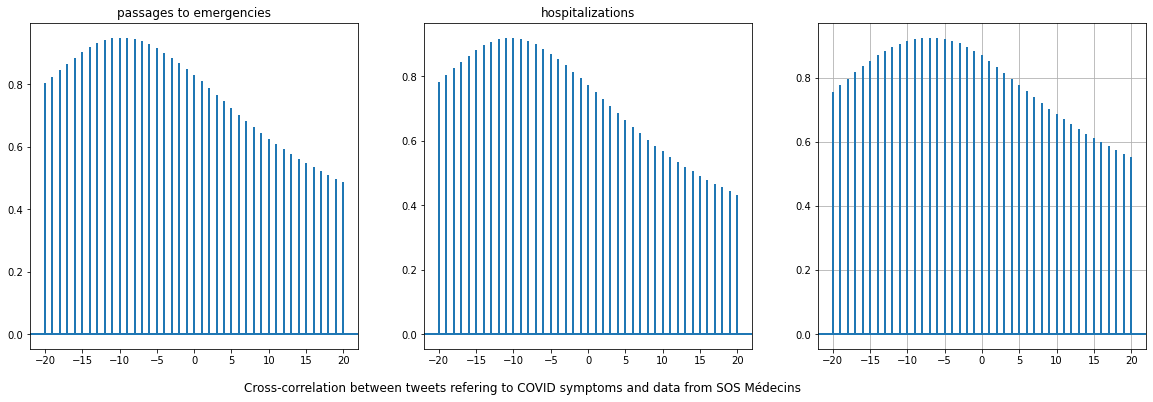

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
for i in range(0,3):
    fig.axes[i].title.set_text(list(emergencies_dict.keys())[i])
    fig.axes[i].xcorr(tweets_day.loc[tweets_day['day'].isin(dates), 'n_symptom'].rolling(7).mean()[6:], 
              emergencies.loc[emergencies['date_de_passage'].isin(dates),list(emergencies_dict.values())[i]].rolling(7).mean()[6:], 
              normed=True, usevlines=True, maxlags=20, lw=2)

    plt.grid(True)
plt.title("Cross-correlation between tweets refering to COVID symptoms and data from SOS Médecins",x=-0.9, y=-0.15)
plt.show()


Here, we note that the maximum of correlation between the two time series seems to be at around 10 days for passages to emergencies and hospitalizations, and around 5 days for medical acts.

Let's then focus on the variable passages to emergencies, with a lag of 10 days.
We first compute the Pearson correlation between the number of passages to emergencies, and the number of tweets mentionning symptoms with a lag of 10 days. 

We use the function [pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) from the package scipy.stats. The Pearson correlation $r$ is defined as follows: 
$$r =  \frac{\sum (x-m_{x})(y-m_{y})}{\sqrt{\sum (x-m_{x})^2 \sum (y-m_{y})^2}}$$
with $m_x$ the mean of vector $x$ and $m_y$ the mean of vector $y$.

In [23]:
import scipy.stats as stats
def pearson_correlation(emergency, lag):
    r, p = stats.pearsonr(tweets_day.loc[tweets_day['day'].isin(dates),'n_symptom'].rolling(7).mean().shift(lag)[16:], 
                          emergencies.loc[emergencies['date_de_passage'].isin(dates), emergency].rolling(7).mean()[16:])
    print(f"Scipy computed Pearson with lag {lag} for", str(emergency), f"r: {r} and p-value: {p}")
    
for emergency in emergencies_dict.values(): 
    pearson_correlation(emergency, lag=10)

Scipy computed Pearson with lag 10 for nbre_pass_corona r: 0.9706527395047325 and p-value: 4.04905836608213e-156
Scipy computed Pearson with lag 10 for nbre_hospit_corona r: 0.958249400640926 and p-value: 2.147069523792077e-137
Scipy computed Pearson with lag 10 for nbre_acte_corona r: 0.7810784373876286 and p-value: 7.683748028457429e-53


## 3.4. Visualize the lagged curves

In [24]:
def plot_symptoms_shifted_emergencies(emergency, lag) :
    
    emergency_type = emergencies_dict.get(emergency)
    
    traces=[]
    traces.append(go.Scatter(x = tweets_day['day'],
                            y = tweets_day['n_symptom'].rolling(7).mean().shift(lag),
                            mode = 'lines',
                             line=dict(color='red'),
                            name = 'Tweets symptoms (avg 7d)',
                            yaxis="y1"))

    traces.append(go.Scatter(x = emergencies['date_de_passage'], 
                             y = emergencies[emergency_type].rolling(7).mean(),
                             mode = 'lines',
                             name = 'Passages to emergencies (avg 7d)',
                             line=dict(color='green'),
                             yaxis="y2"))

    layout = go.Layout(title="Evolution of mentions of symptoms (shifted 10 days) and emergencies related to COVID in Ile-de-France",
                        legend={"x" : 1.08, "y" : 1},
                       yaxis=dict(title='Number of tweets'),
                       yaxis2=dict(title='Number of '+str(emergency),
                                   overlaying='y',
                                   side='right'))
    
    fig = go.Figure(traces, layout)
    py.iplot(fig)
    
    pearson_correlation(emergency_type, lag)

In [25]:
interact(plot_symptoms_shifted_emergencies, 
         emergency=widgets.Dropdown(options=emergencies_dict.keys(),
                                        value='passages to emergencies'),
        lag=widgets.IntSlider(value=10,
                              min=0,
                              max=20,
                              step=1,
                              description='lag (days)'))

interactive(children=(Dropdown(description='emergency', options=('passages to emergencies', 'hospitalizations'…

<function __main__.plot_symptoms_shifted_emergencies(emergency, lag)>

# 4. Your turn! Do you have other ideas of data analysis and visualization?

Some suggestions about what you could do:
- **Try other filtering rules to detect self-reported symptoms in the tweets.** For example, we noticed a lot of tweets mentioning symptoms are not about self-reported symptoms (symptoms that the tweet author or one of their relatives are experiencing, but they are jokes or general news). Could you think of some rules to automatically remove those tweets?
- **Try the same visualizations with other datasets.** Santé Publique France gives access to other datasets ([Hospital data](https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/), [Tests data](https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-tests-de-depistage-de-covid-19-realises-en-laboratoire-de-ville/)) ; you can also try to use the [Data from OpenCOVID19-fr](https://www.data.gouv.fr/en/datasets/chiffres-cles-concernant-lepidemie-de-covid19-en-france/) about mortality due to COVID19.

## 4.1. Detect true positive tweets

We notice there are a lot of false positives in our tweets, for example, tweets about general news about the virus. We want to filter those tweets out, and focus only on the tweets mentioning the user's or one of their relatives' symptoms. We believe that tweets with an hashtag or an url are more likely to contain general news than tweets about self-reported symptoms. We also want to select only the tweets containing pronouns - if these tweets, the user is talking about themself - , and the tweets that start with a symptom - some tweets are just lists of symptoms.

In [26]:
tweets_symptoms.head()

,id_str,day,anonymized_text,clean_text,cough,sore_throat,fever,loss_taste,breathing_difficulties,symptoms,n_symptom
0,1206157336534016001,2019-12-15,Symptomatique [url],symptomatique [url],False,False,False,False,False,True,1
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...,reformeretraite delevoye @mention appelle au...,False,False,False,False,False,True,1
2,1216811655738413056,2020-01-13,@mention @mention Rhume toux fièvre,@mention @mention rhume toux fievre,True,False,True,False,False,False,1
3,1218113362917236737,2020-01-17,Il serait temps de condamner toutes ces feigna...,il serait temps de condamner toutes ces feigna...,False,False,False,False,False,False,1
4,1219872603554361344,2020-01-22,@mention Parce que ça veut dire que je serais ...,@mention parce que ca veut dire que je serais ...,False,False,True,False,False,False,1


In [27]:
def keep_self_reported(tweets):
    
    # remove tweets with url
    tweets['has_url']=...
    # remove tweets mentionning hasthags
    tweets['has_hastag']=...
    # keep only tweets with pronoun ('je', 'mon', 'ma', ...)
    tweets['has_pronoun']=...
    # keep also tweets that starts with symptom
    tweets['starts_symptom']=...
    
    # define which tweets to keep
    tweets['true_positive']=(tweets['has_url']==0) & (tweets['has_hashtag']==0) & 
    ((tweets['has_pronoun']==1) | (tweets['starts_symptom']==1))
    
    return tweets

## 4.2. Death data

In [28]:
death_data=pd.read_csv('https://www.data.gouv.fr/en/datasets/r/0b66ca39-1623-4d9c-83ad-5434b7f9e2a4', sep=',')
death_data.head()

,date,granularite,maille_code,maille_nom,cas_confirmes,cas_ehpad,cas_confirmes_ehpad,cas_possibles_ehpad,deces,deces_ehpad,reanimation,hospitalises,nouvelles_hospitalisations,nouvelles_reanimations,gueris,depistes,source_nom,source_url,source_archive,source_type
0,2020-01-24,departement,DEP-16,Charente,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,NaN,agences-regionales-sante
1,2020-01-24,departement,DEP-17,Charente-Maritime,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,NaN,agences-regionales-sante
2,2020-01-24,departement,DEP-19,Corrèze,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,NaN,agences-regionales-sante
3,2020-01-24,departement,DEP-23,Creuse,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,NaN,agences-regionales-sante
4,2020-01-24,departement,DEP-24,Dordogne,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,NaN,agences-regionales-sante


In [54]:
def clean_death_data():
    # keep only Île-de-France
    ...
    # 'deces' variable is cumulative, calculate the number of new deaths per day
    ...
    return df

In [ ]:
# plot this data with the number of tweets mentioning symptoms
def plot_tweets_death():
    ...